# **Install and Import Packages**

In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 KB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.0+cu118 and Flower 1.3.0


# **Loading the Data**
**CIFAR-10:** dataset for classifying images https://www.tensorflow.org/datasets/catalog/cifar10

In [ ]:
#Define Label Classes
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [ ]:
#Define Number of Clients
#16 Unique Sources for 16 Cell Phones
NUM_CLIENTS = 16

# **Define Batch Size and Load & Split Dataset**

In [ ]:
BATCH_SIZE = 50


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

100%|██████████| 170498071/170498071 [00:01<00:00, 88773328.85it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


# **Label Configuration**

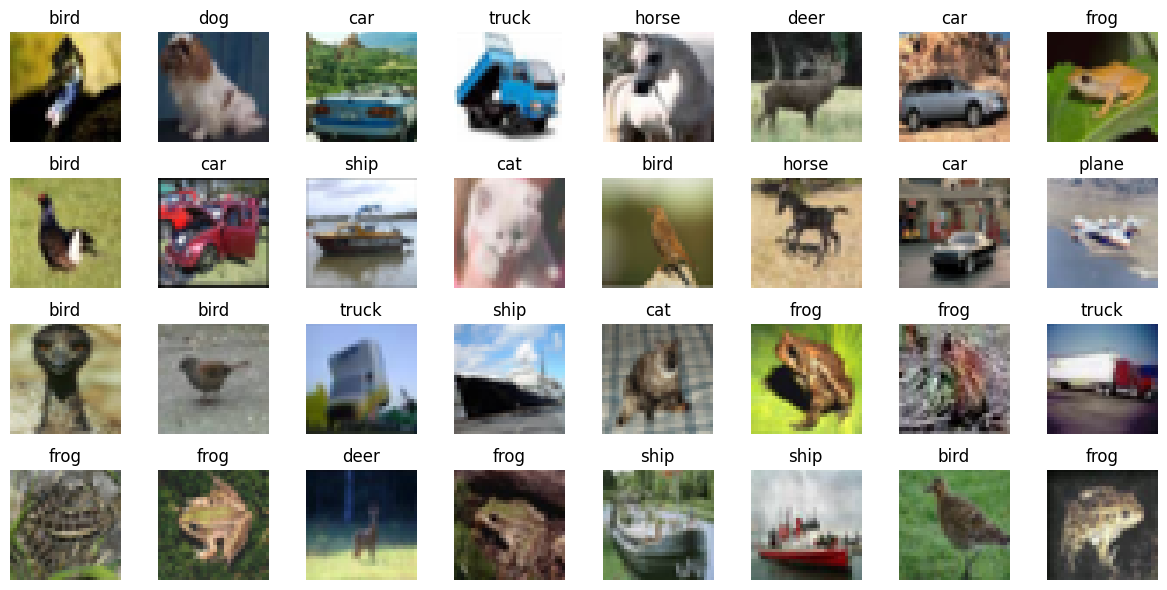

In [ ]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

# **Step 1: Centralized Training with PyTorch**



# **Algorithmn Selection Convolutional Neural Network**

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# **Training and test functions**

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# **Training the model**

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.04542837502100529, accuracy 0.3141025641025641
Epoch 2: validation loss 0.04167312880357107, accuracy 0.3333333333333333
Epoch 3: validation loss 0.04100991861942487, accuracy 0.34615384615384615
Epoch 4: validation loss 0.03934343732320345, accuracy 0.38461538461538464
Epoch 5: validation loss 0.038237898013530634, accuracy 0.40705128205128205
Final test set performance:
	loss 0.03472005017995834
	accuracy 0.3605


# **Step 2: Federated Learning with Flower**

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# **Implementing a Flower client**

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

# **Using the Virtual Client Engine**

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

# **Starting the training**

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.25,  # Sample 25% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-08 22:52:24,485 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-08 22:52:26,585	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-08 22:52:28,100 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3959858380.0, 'memory': 7919716763.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3959858380.0, 'memory': 7919716763.0, 'GPU': 1.0}
INFO flwr 2023-04-08 22:52:28,109 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-08 22:52:28,117 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


History (loss, distributed):
	round 1: 0.04672296337592295
	round 2: 0.041530854885394757
	round 3: 0.03915334129944826
	round 4: 0.0370834014354608
	round 5: 0.03714449848884192

# **Using the Virtual Client Engine**

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# **Strategy to call this function whenever it receives evaluation metric dictionaries from the clients**

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-08 22:58:03,587 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-08 22:58:09,080	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-08 22:58:10,651 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3973443993.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7946887988.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3973443993.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7946887988.0, 'CPU': 2.0}
INFO flwr 2023-04-08 22:58:10,658 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-08 22:58:10,665 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


History (loss, distributed):
	round 1: 0.04607737279282166
	round 2: 0.04201568758640533
	round 3: 0.039892598413504086
	round 4: 0.0384670229963003
	round 5: 0.037507578873863585
History (metrics, distributed):
{'accuracy': [(1, 0.27323717948717957), (2, 0.3145032051282052), (3, 0.36017628205128205), (4, 0.3737980769230769), (5, 0.391426282051282)]}

# **Save the Model**

In [ ]:
# Save model
torch.save(net.state_dict(), "model.pth")

In [ ]:
# Load model
net = Net()
net.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

# **Convert to Onnx Format**

In [ ]:
import torch.onnx

In [ ]:
!pip install onnx2mpc


In [ ]:
dummy_input = torch.randn(1, 3, 32, 32)
torch.onnx.export(Net(), dummy_input, "model.onnx", input_names=["input"], output_names=["output"])

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# **Convert Onnx Model to Binary Code**

In [ ]:
import subprocess
import os

In [ ]:
#!xxd -i model.onnx

In [ ]:
# Read the ONNX model from file
with open('model.onnx', 'rb') as f:
    model_bytes = f.read()

# Convert the model to bytecode
model_bytecode = []
for b in model_bytes:
    model_bytecode.append(hex(b))

In [ ]:
model_bytecode

['0x8',
 '0x7',
 '0x12',
 '0x7',
 '0x70',
 '0x79',
 '0x74',
 '0x6f',
 '0x72',
 '0x63',
 '0x68',
 '0x1a',
 '0x5',
 '0x32',
 '0x2e',
 '0x30',
 '0x2e',
 '0x30',
 '0x3a',
 '0x99',
 '0x9f',
 '0xf',
 '0xa',
 '0xaa',
 '0x1',
 '0xa',
 '0x7',
 '0x69',
 '0x6e',
 '0x70',
 '0x75',
 '0x74',
 '0x2e',
 '0x31',
 '0xa',
 '0xc',
 '0x63',
 '0x6f',
 '0x6e',
 '0x76',
 '0x31',
 '0x2e',
 '0x77',
 '0x65',
 '0x69',
 '0x67',
 '0x68',
 '0x74',
 '0xa',
 '0xa',
 '0x63',
 '0x6f',
 '0x6e',
 '0x76',
 '0x31',
 '0x2e',
 '0x62',
 '0x69',
 '0x61',
 '0x73',
 '0x12',
 '0x14',
 '0x2f',
 '0x63',
 '0x6f',
 '0x6e',
 '0x76',
 '0x31',
 '0x2f',
 '0x43',
 '0x6f',
 '0x6e',
 '0x76',
 '0x5f',
 '0x6f',
 '0x75',
 '0x74',
 '0x70',
 '0x75',
 '0x74',
 '0x5f',
 '0x30',
 '0x1a',
 '0xb',
 '0x2f',
 '0x63',
 '0x6f',
 '0x6e',
 '0x76',
 '0x31',
 '0x2f',
 '0x43',
 '0x6f',
 '0x6e',
 '0x76',
 '0x22',
 '0x4',
 '0x43',
 '0x6f',
 '0x6e',
 '0x76',
 '0x2a',
 '0x12',
 '0xa',
 '0x9',
 '0x64',
 '0x69',
 '0x6c',
 '0x61',
 '0x74',
 '0x69',
 '0x6f',
 '0x6e',


In [ ]:
# Opening a file named "model_onnx_bytecode.txt" in write mode
file = open("model_onnx_bytecode.txt", "w")

# Using the repr() function to convert the string values to their string representation
model_bytecode = repr(model_bytecode)

# Writing the bytecode with appropriate labels
file.write(model_bytecode)

# Closing the file
file.close

<function TextIOWrapper.close()>